# New Train/Val/Set

Creates new train/val/test set using the raw data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import utils
import scipy
import paths
import sklearn.model_selection 


Bad key "text.kerning_factor" on line 4 in
/home/rlopez/miniconda3/envs/ccs/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
paths_dic = paths.get_paths()

In [5]:
df1 = pd.read_csv(paths_dic['data']+'SourceData_Figure_1.csv')
df1.loc[:,'Modified sequence'] = df1['Modified sequence'].str.replace('_','')

In [6]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(df1, df1['CCS'], random_state=3122021, stratify=df1['Charge'])

# Linear Regression

In [7]:
import regression_linear

In [8]:
lr = regression_linear.LinearRegression()
lr.fit(x_train)

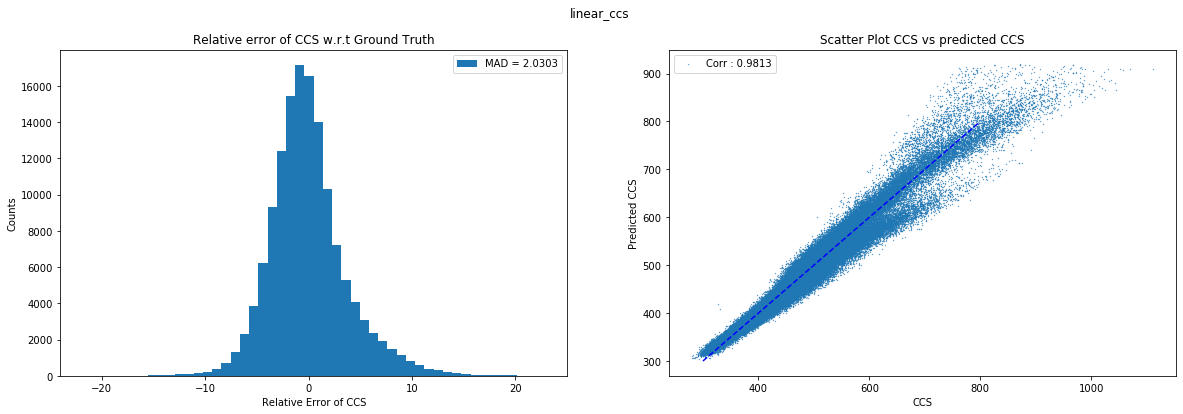

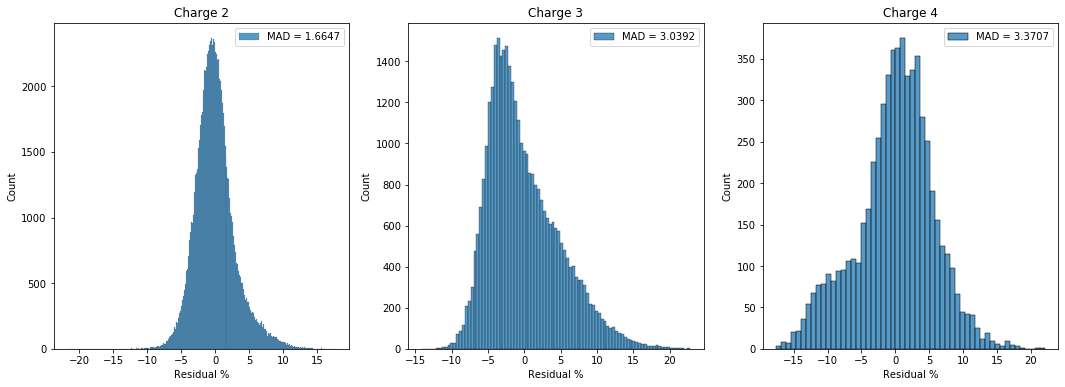

In [9]:
lr.test_set_plot(x_test)

# Power Law Regression

In [10]:
import regression_power

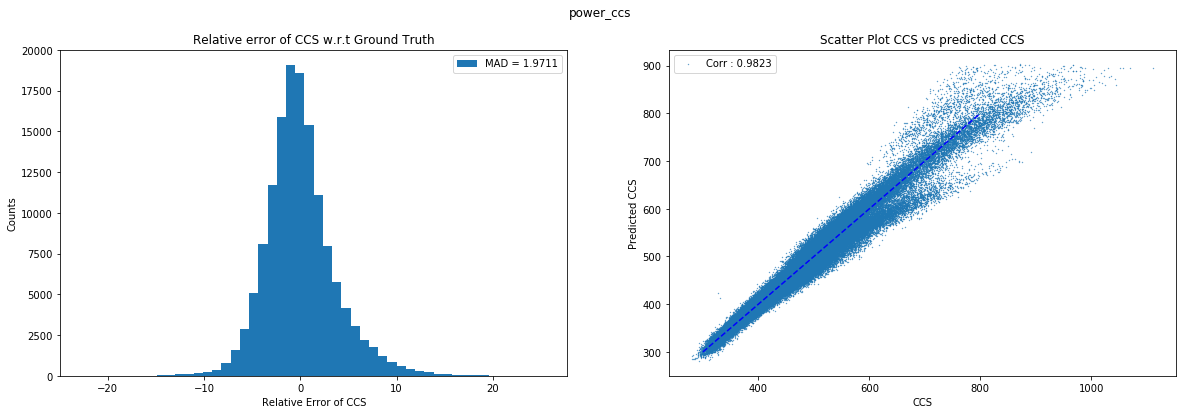

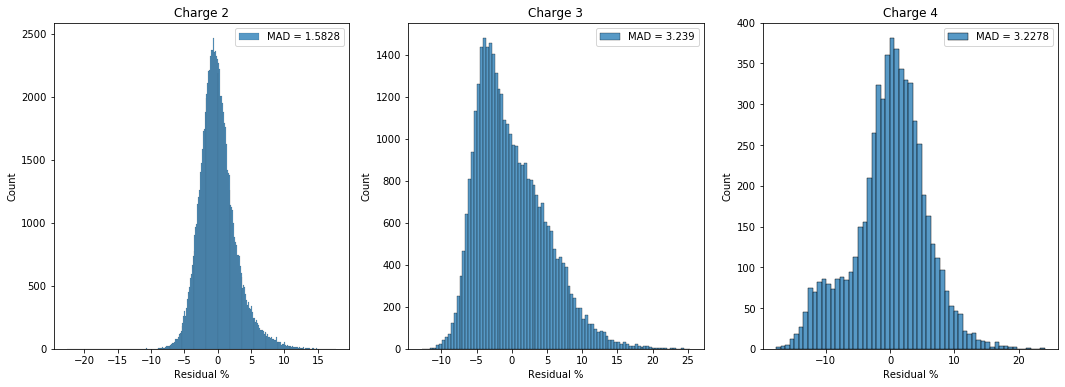

In [11]:
pl = regression_power.PowerLawRegression()
pl.fit(x_train)
pl.test_set_plot(x_test)

# SVR Counts

In [27]:
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import BaggingRegressor
from sklearnex import patch_sklearn
import scipy

In [13]:
patch_sklearn()


Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [14]:
features_complete =  np.load(paths_dic['data']+'counts_fig1.npy', allow_pickle=True)

In [15]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(features_complete, df1['CCS'], random_state=3122021, stratify=features_complete[:,-1])

In [16]:
n_estimators = 10
regr2 = BaggingRegressor(base_estimator=LinearSVR(dual =False, loss='squared_epsilon_insensitive'), n_estimators=n_estimators, 
random_state=0, n_jobs=-1, max_samples= 1.0/n_estimators, verbose = 1)
regr3 = BaggingRegressor(base_estimator=LinearSVR(dual =False, loss='squared_epsilon_insensitive'), n_estimators=n_estimators, 
random_state=0, n_jobs=-1, max_samples= 1.0/n_estimators, verbose = 1)
regr4 = BaggingRegressor(base_estimator=LinearSVR(dual =False, loss='squared_epsilon_insensitive'), n_estimators=n_estimators, 
random_state=0, n_jobs=-1, max_samples= 1.0/n_estimators, verbose = 1)

In [17]:
regr2.fit(x_train[x_train[:,-1]==2][:,:-1], y_train[x_train[:,-1]==2])
regr3.fit(x_train[x_train[:,-1]==3][:,:-1], y_train[x_train[:,-1]==3])
regr4.fit(x_train[x_train[:,-1]==4][:,:-1], y_train[x_train[:,-1]==4])

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.3s remaining:    5.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


BaggingRegressor(base_estimator=LinearSVR(dual=False,
                                          loss='squared_epsilon_insensitive'),
                 max_samples=0.1, n_jobs=-1, random_state=0, verbose=1)

In [30]:
preds = pd.DataFrame(df1.loc[y_test.index][['Charge', 'CCS']], columns = ['Charge', 'CCS'])
preds['svr'] = 0

In [31]:
preds.loc[preds['Charge']==2, 'svr'] = regr2.predict(x_test[x_test[:,-1]==2][:,:-1]) 
preds.loc[preds['Charge']==3, 'svr'] = regr3.predict(x_test[x_test[:,-1]==3][:,:-1])
preds.loc[preds['Charge']==4, 'svr'] = regr4.predict(x_test[x_test[:,-1]==4][:,:-1])

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.9s remaining:    3.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


In [32]:
res_rel = (preds['svr']-y_test)/y_test*100

Creating histogram
Creating scatter plot


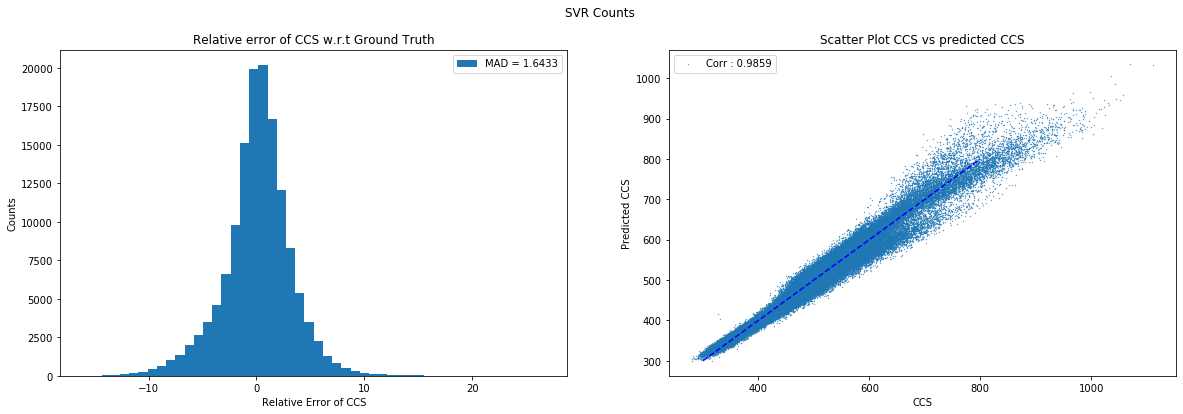

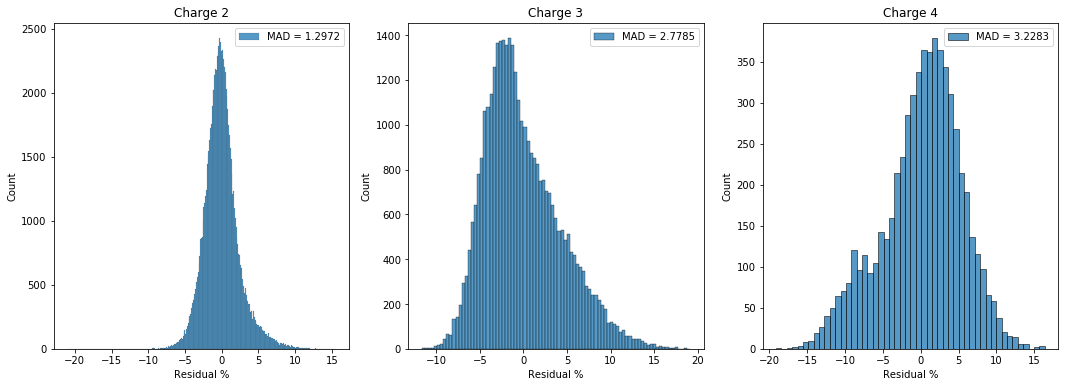

In [33]:
print('Creating histogram')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))
fig.suptitle('SVR Counts', fontsize = 12)
ax[0].hist(res_rel, bins = 50, label = f'MAD = {np.round(scipy.stats.median_abs_deviation(res_rel), 4)}')
ax[0].set_xlabel('Relative Error of CCS')
ax[0].set_ylabel('Counts')
ax[0].set_title('Relative error of CCS w.r.t Ground Truth')
ax[0].legend()

print('Creating scatter plot')
corr, _ = scipy.stats.pearsonr(preds['svr'],y_test)
ax[1].scatter(y_test, preds['svr'], label = f'Corr : {np.round(corr, 4)}', s = 0.1)
ax[1].set_xlabel('CCS')
ax[1].set_ylabel('Predicted CCS')
ax[1].set_title('Scatter Plot CCS vs predicted CCS')
ax[1].plot(np.arange(300,800), np.arange(300,800), 'b--')
ax[1].legend()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
i = 0
for ax, df_it in zip(ax, [preds[preds['Charge']==2], preds[preds['Charge']==3], preds[preds['Charge']==4]]):
    res_rel = (df_it['CCS']-df_it['svr'])/df_it['svr']*100
    sns.histplot(res_rel, ax = ax, label = f'MAD = {np.round(scipy.stats.median_abs_deviation(res_rel), 4)}')
    ax.set_xlabel('Residual %')
    ax.set_ylabel('Count')
    ax.set_title(f'Charge {i+2}')
    ax.legend()
    i += 1
